In [833]:
import sys  
sys.path.append("../..")
from bernSCM.run_bernSCM import *

from fair.SSPs import ssp245,ssp585
from fair import *
import country_converter as coco

import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

%matplotlib inline

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =30
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize'] = 20 #30
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.major.pad']='8'
mpl.rcParams['ytick.major.pad']='8'

### 1. Concentration based run
We first need to find emissions that ensure a constant atmospheric $CH_4$ concentration after the year of the pulse.

In [2]:
conc_in = return_empty_emissions(df_to_copy=False, start_year=1765, end_year=3100, timestep=1, scen_names=['yr_'+str(i) for i in range(1850,2006)], gases_in = ['methane'])

for label in ['yr_'+str(i) for i in range(1850,2016)]:
    t = int(label.split('yr_')[-1])

    conc_in.loc[:t,(label,'methane')]=ssp245.Concentrations.ch4[ssp245.Concentrations.year<=t]
    conc_in.loc[t:,(label,'methane')]=ssp245.Concentrations.ch4[ssp245.Concentrations.year==t]

test_gas = get_gas_parameter_defaults().reindex(conc_in.columns.levels[1],axis=1,level=1)

In [3]:
conc_out = run_FaIR(concentrations_in=conc_in,forcing_in=return_empty_forcing(conc_in),gas_parameters=test_gas,thermal_parameters=get_thermal_parameter_defaults())

Integrating 166 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['methane'] forcing agents, between 1765 and 3100...


100%|██████████| 1335/1335 [00:00<00:00, 1848.83 timestep/s]


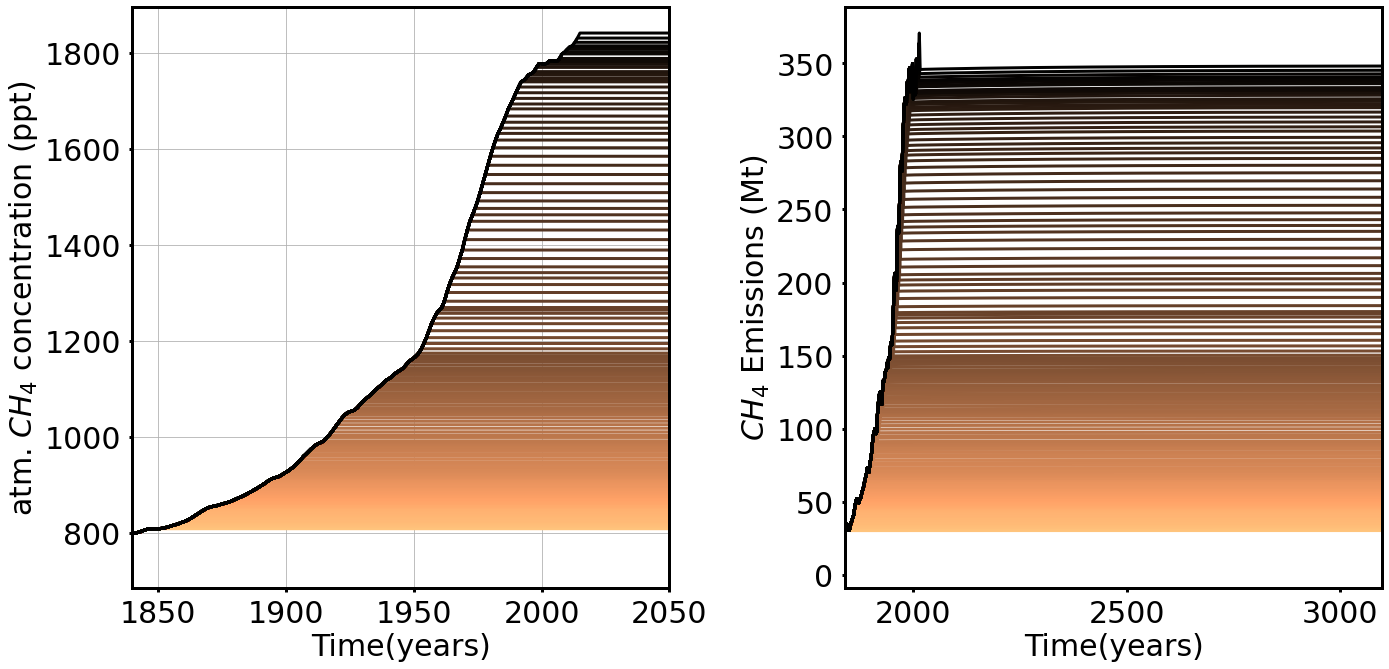

In [4]:
fig=plt.figure(1,figsize=(20,10))
ax1=plt.subplot(121)
conc_out['C'].plot(legend=False,cmap='copper_r',ax=ax1)
ax1.set_ylabel(r'atm. $CH_4$ concentration (ppt)')
ax1.set_xlabel('Time(years)')
ax1.set_xlim(1840,2050)
ax1.grid()
ax2=plt.subplot(122)
ax2.set_xlim(1840,3100)
conc_out['Emissions'].plot(legend=False,cmap='copper_r',ax=ax2)
ax2.set_ylabel(r'$CH_4$ Emissions (Mt)')
ax2.set_xlabel('Time(years)')
fig.tight_layout();

Convert emission output from the concentration based run to an input DataFrame (delete the Gas cycle row and rename to Gas):

In [5]:
control_in = conc_out['Emissions'].droplevel(1,axis=1)
control_in.columns = control_in.columns.rename("Gas", level=1)

## 2. Control run

In [6]:
control_out = run_FaIR(emissions_in=control_in,forcing_in=return_empty_forcing(control_in),gas_parameters=test_gas,thermal_parameters=get_thermal_parameter_defaults())

Integrating 166 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['methane'] forcing agents, between 1765 and 3100...


100%|██████████| 1335/1335 [00:00<00:00, 1687.39 timestep/s]


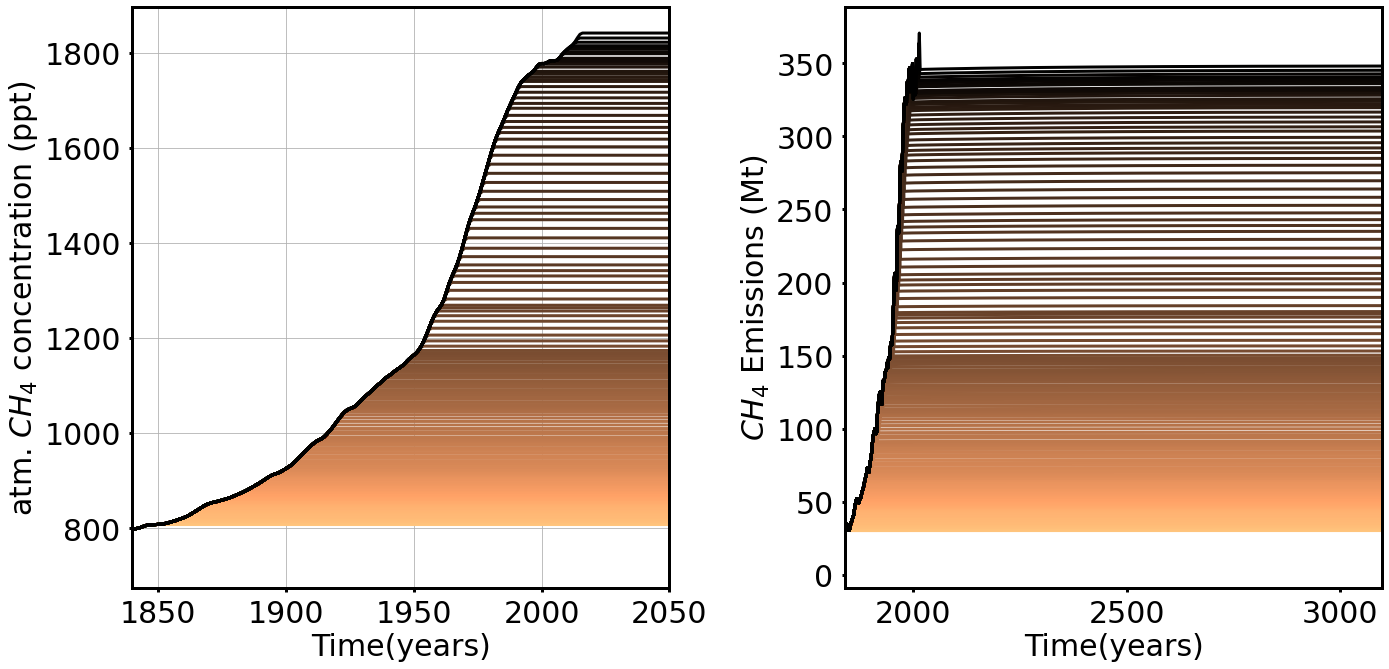

In [7]:
fig=plt.figure(1,figsize=(20,10))
ax1=plt.subplot(121)
control_out['C'].plot(legend=False,cmap='copper_r',ax=ax1)
ax1.set_ylabel(r'atm. $CH_4$ concentration (ppt)')
ax1.set_xlabel('Time(years)')
ax1.set_xlim(1840,2050)
ax1.grid()
ax2=plt.subplot(122)
ax2.set_xlim(1840,3100)
control_out['Emissions'].plot(legend=False,cmap='copper_r',ax=ax2)
ax2.set_ylabel(r'$CH_4$ Emissions (Mt)')
ax2.set_xlabel('Time(years)')
fig.tight_layout();

## 3. Get Methane data

In [29]:
primap = pd.read_csv('data/Guetschow-et-al-2021-PRIMAP-hist_v2.3.1_20-Sep_2021.csv')

In [41]:
primap.columns

Index(['source', 'scenario (PRIMAP-hist)', 'area (ISO3)', 'entity', 'unit',
       'category (IPCC2006_PRIMAP)', '1750', '1751', '1752', '1753',
       ...
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019'],
      dtype='object', length=276)

In [43]:
primap = primap.rename(columns={"category (IPCC2006_PRIMAP)": "category",
                                "area (ISO3)":"ISO3",
                                "scenario (PRIMAP-hist)":"scenario"})

In [58]:
#select the HISTCR scenario (country-reported data is prioritized over third-party data)
primap = primap[primap.scenario=='HISTCR']

# select National Total excluding LULUCF
primap = primap[primap.category=='M.0.EL']

In [510]:
primap

source scenario ISO3                entity         unit  \
7      PRIMAP-hist_v2.3.1   HISTCR  ABW                   CH4  Gg CH4 / yr   
16     PRIMAP-hist_v2.3.1   HISTCR  ABW                   CO2  Gg CO2 / yr   
26     PRIMAP-hist_v2.3.1   HISTCR  ABW  KYOTOGHG (AR4GWP100)  Gg CO2 / yr   
38     PRIMAP-hist_v2.3.1   HISTCR  ABW  KYOTOGHG (SARGWP100)  Gg CO2 / yr   
51     PRIMAP-hist_v2.3.1   HISTCR  ABW                   N2O  Gg N2O / yr   
...                   ...      ...  ...                   ...          ...   
14089  PRIMAP-hist_v2.3.1   HISTCR  ZWE                   CH4  Gg CH4 / yr   
14101  PRIMAP-hist_v2.3.1   HISTCR  ZWE                   CO2  Gg CO2 / yr   
14113  PRIMAP-hist_v2.3.1   HISTCR  ZWE  KYOTOGHG (AR4GWP100)  Gg CO2 / yr   
14125  PRIMAP-hist_v2.3.1   HISTCR  ZWE  KYOTOGHG (SARGWP100)  Gg CO2 / yr   
14137  PRIMAP-hist_v2.3.1   HISTCR  ZWE                   N2O  Gg N2O / yr   

      category       1750        1751        1752        1753  ...  \
7       M.0.EL   0.014000    0.014100    0.014200    0.014300  ...   
16      M.0.EL   0.000000    0.000000    0.000000    0.000000  ...   
26      M.0.EL   0.365000    0.369000    0.373000    0.377000  ...   
38      M.0.EL   0.310000    0.314000    0.317000    0.321000  ...   
51      M.0.EL   0.000052    0.000056    0.000061    0.000065  ...   
...        ...        ...         ...         ...         ...  ...   
14089   M.0.EL   3.700000    3.770000    3.840000    3.900000  ...   
14101   M.0.EL   0.000000    0.000000    0.000000    0.000000  ...   
14113   M.0.EL  98.100000  100.000000  103.000000  105.000000  ...   
14125   M.0.EL  83.500000   85.700000   87.800000   90.000000  ...   
14137   M.0.EL   0.018500    0.021000    0.023500    0.025900  ...   

             2010       2011        2012        2013        2014        2015  \
7          1.4300      2.040      1.2400      1.6200      1.5100      1.3900   
16      2510.0000   2500.000   1350.0000    866.0000    877.0000    903.0000   
26      2560.0000   2570.000   1400.0000    925.0000    934.0000    956.0000   
38      2560.0000   2560.000   1400.0000    919.0000    928.0000    951.0000   
51         0.0522      0.049      0.0638      0.0616      0.0637      0.0626   
...           ...        ...         ...         ...         ...         ...   
14089    307.0000    319.000    308.0000    298.0000    265.0000    291.0000   
14101   8620.0000  10400.000   8440.0000  12500.0000  12900.0000  13000.0000   
14113  22000.0000  24200.000  21600.0000  25100.0000  24200.0000  25400.0000   
14125  21000.0000  23200.000  20600.0000  24100.0000  23300.0000  24400.0000   
14137     19.2000     19.700     18.2000     17.3000     15.4000     17.0000   

             2016        2017        2018        2019  
7          1.2800      1.1700      1.1400      1.1300  
16       888.0000    936.0000    966.0000    999.0000  
26       939.0000    982.0000   1010.0000   1050.0000  
38       934.0000    978.0000   1010.0000   1040.0000  
51         0.0628      0.0572      0.0557      0.0608  
...           ...         ...         ...         ...  
14089    267.0000    274.0000    281.0000    280.0000  
14101  11700.0000  11300.0000  11900.0000  11900.0000  
14113  23000.0000  23000.0000  23900.0000  23800.0000  
14125  22200.0000  22100.0000  22900.0000  22900.0000  
14137     15.7000     16.3000     16.7000     16.6000  

[1896 rows x 276 columns]

In [109]:
ch4 = primap[primap.entity=='CH4'].set_index('ISO3')
ch4= ch4.loc[:,[str(t) for t in range(1750,2020)]]
ch4.columns = ch4.columns.astype('int')
# convert Gg to Mt
ch4 = ch4/1000

In [110]:
ch4

1750      1751      1752      1753      1754      1755      1756  \
ISO3                                                                         
ABW   0.000014  0.000014  0.000014  0.000014  0.000014  0.000015  0.000015   
AFG   0.085000  0.085400  0.085700  0.086100  0.086400  0.086800  0.087100   
AGO   0.057100  0.057100  0.057100  0.057100  0.057100  0.057200  0.057200   
AIA   0.000003  0.000003  0.000003  0.000003  0.000003  0.000003  0.000003   
ALB   0.015200  0.015300  0.015300  0.015400  0.015400  0.015500  0.015500   
...        ...       ...       ...       ...       ...       ...       ...   
WSM   0.000228  0.000230  0.000231  0.000232  0.000233  0.000234  0.000236   
YEM   0.060900  0.061000  0.061100  0.061200  0.061300  0.061400  0.061500   
ZAF   0.009920  0.009950  0.009990  0.010000  0.010100  0.010100  0.010100   
ZMB   0.017900  0.017900  0.017900  0.017900  0.017900  0.017900  0.017900   
ZWE   0.003700  0.003770  0.003840  0.003900  0.003970  0.004030  0.004100   

          1757      1758      1759  ...      2010      2011      2012  \
ISO3                                ...                                 
ABW   0.000015  0.000015  0.000015  ...  0.001430  0.002040  0.001240   
AFG   0.087500  0.087800  0.088200  ...  0.632000  0.652000  0.649000   
AGO   0.057200  0.057200  0.057200  ...  2.190000  2.120000  2.130000   
AIA   0.000003  0.000003  0.000003  ...  0.000143  0.000144  0.000146   
ALB   0.015600  0.015600  0.015700  ...  0.094300  0.094400  0.096000   
...        ...       ...       ...  ...       ...       ...       ...   
WSM   0.000237  0.000238  0.000239  ...  0.006880  0.007100  0.007150   
YEM   0.061600  0.061700  0.061800  ...  0.340000  0.360000  0.374000   
ZAF   0.010100  0.010200  0.010200  ...  2.390000  2.470000  2.530000   
ZMB   0.017900  0.017900  0.017900  ...  0.645000  0.625000  0.692000   
ZWE   0.004170  0.004230  0.004300  ...  0.307000  0.319000  0.308000   

          2013     2014      2015      2016      2017      2018      2019  
ISO3                                                                       
ABW   0.001620  0.00151  0.001390  0.001280  0.001170  0.001140  0.001130  
AFG   0.649000  0.66400  0.635000  0.630000  0.625000  0.636000  0.666000  
AGO   2.170000  2.11000  2.220000  2.190000  2.170000  2.110000  2.170000  
AIA   0.000148  0.00015  0.000151  0.000152  0.000153  0.000154  0.000159  
ALB   0.096800  0.09880  0.101000  0.100000  0.101000  0.101000  0.098000  
...        ...      ...       ...       ...       ...       ...       ...  
WSM   0.007300  0.00759  0.007960  0.008150  0.007980  0.008160  0.008300  
YEM   0.396000  0.38900  0.334000  0.319000  0.320000  0.311000  0.328000  
ZAF   2.450000  2.48000  2.460000  2.450000  2.420000  2.410000  2.440000  
ZMB   0.705000  0.70300  0.714000  0.710000  0.689000  0.698000  0.713000  
ZWE   0.298000  0.26500  0.291000  0.267000  0.274000  0.281000  0.280000  

[214 rows x 270 columns]

<AxesSubplot:>

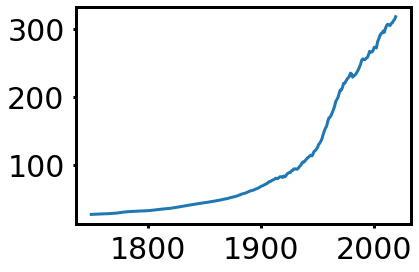

In [125]:
ch4.loc['EARTH'].plot()

In [130]:
import copy
pulse_in = copy.deepcopy(control_in)
for t in range(1850,2016):
    pulse_in.loc[t,'yr_'+str(t)].methane = pulse_in.loc[t,'yr_'+str(t)].methane + ch4.loc['EARTH',t]

In [140]:
pulse_out = run_FaIR(emissions_in=pulse_in,forcing_in=return_empty_forcing(pulse_in),gas_parameters=test_gas,thermal_parameters=get_thermal_parameter_defaults())

Integrating 166 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['methane'] forcing agents, between 1765 and 3100...


100%|██████████| 1335/1335 [00:00<00:00, 1448.08 timestep/s]


In [141]:
# each century own color, shading for decadals
l = []
for c in [["546A7B",5],["62929E",10],["C6C5B9",2]]:
    l = l+ [(colors.to_rgba('#'+c[0],i)) for i in np.linspace(0.2,1,10)]*c[1]
# remove last 4 years
l = l[:-4]

co2_cmap=colors.ListedColormap(l)

# each century own color, shading for decadals
l = []
for c in [["9E2A2B",5],["BF6535",10],["E09F3E",2]]:
    l = l+ [(colors.to_rgba('#'+c[0],i)) for i in np.linspace(0.2,1,10)]*c[1]
# remove last 5 years
l = l[:-4]

T_cmap=colors.ListedColormap(l)

In [642]:
1e-1

0.1

In [779]:
ch4_diff = (pulse_out['C']-control_out['C']).droplevel(1,axis=1).droplevel(1,axis=1)
# cut all values smaller than zero to zero (because of error propagation)
ch4_diff[ch4_diff <0]=0

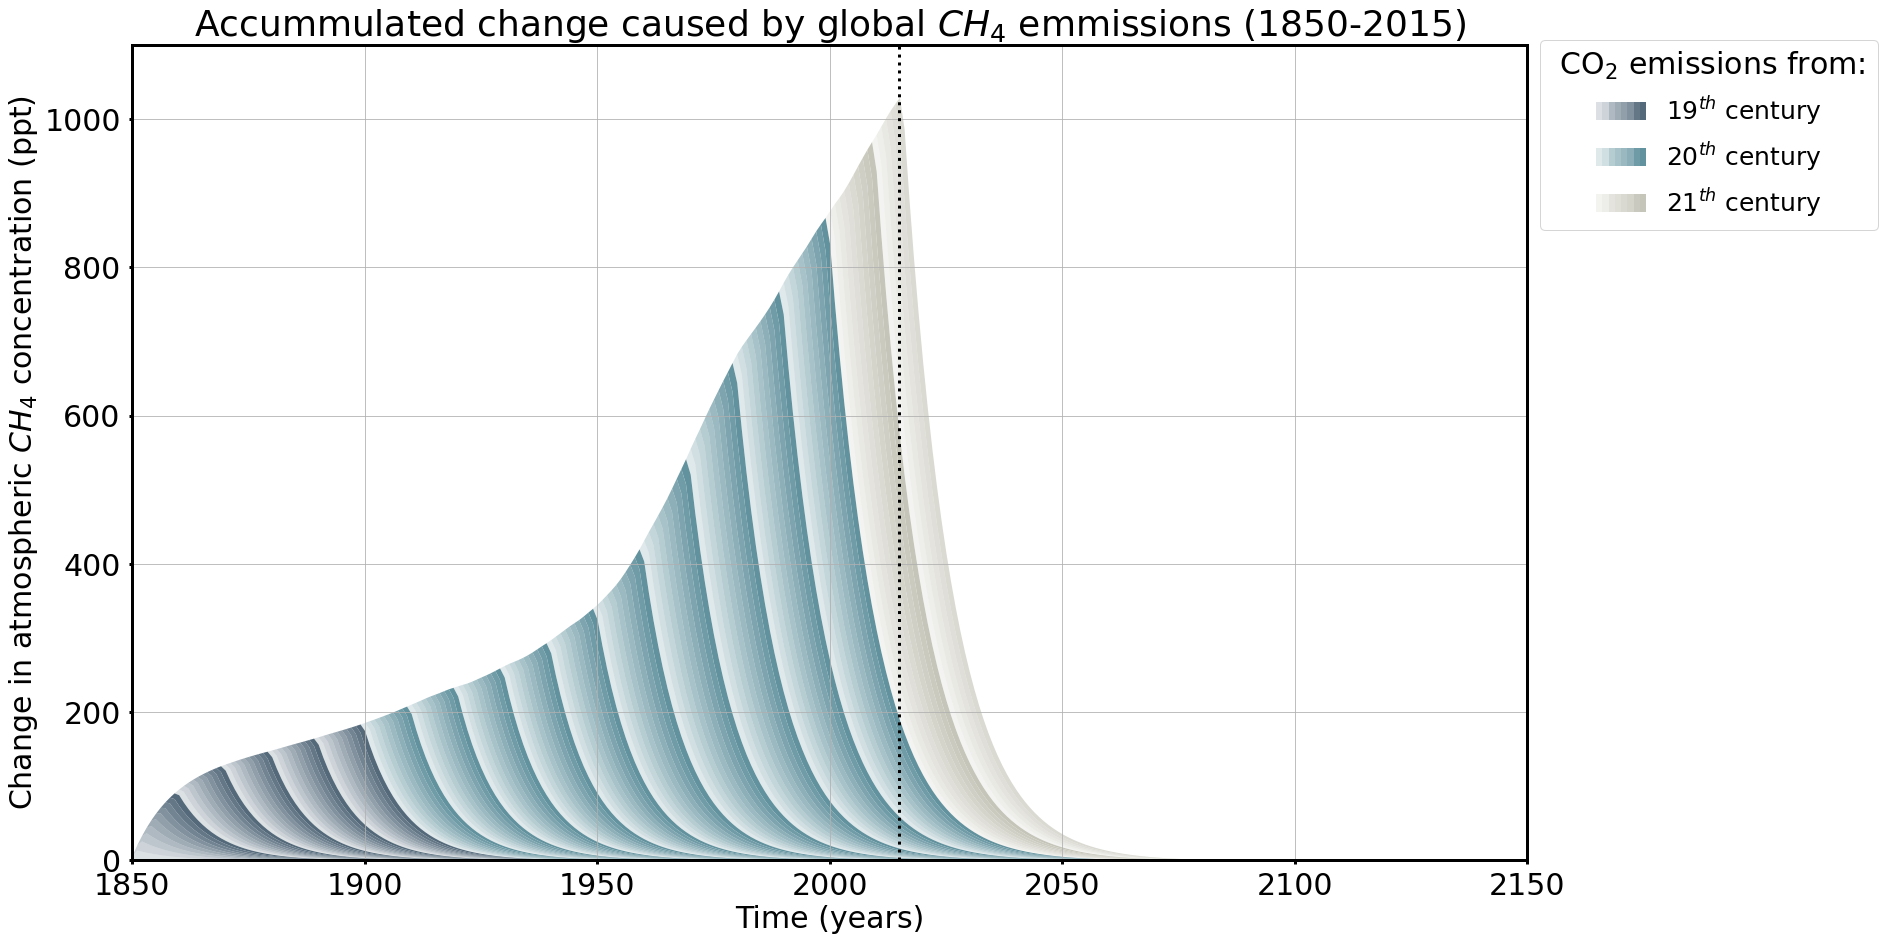

In [780]:
fig = plt.figure(figsize=(25, 15))
grid = plt.GridSpec(1, 1, hspace=0.2, wspace=0)
ax1 = plt.subplot(grid[0])

#ch4_diff = (pulse_out['C']-control_out['C']).droplevel(1,axis=1).round(1)
ch4_diff.loc[:2100,:].plot.area(legend=False, linewidth=0,ax=ax1,cmap=co2_cmap)

ax1.grid()

ax1.axvline(2015,linestyle=':',c='k')
ax1.set_xlim(1850,2150)

ax1.set_ylim(0,1100)

ax1.set_xlabel(None)

ax1.set_ylabel(r'Change in atmospheric $CH_4$ concentration (ppt)')
ax1.set_xlabel('Time (years)', ha='center')

ax1.set_title(r'Accummulated change caused by global $CH_4$ emmissions (1850-2015)')

# legend
cmap_labels = [r'19$^{th}$ century', r'20$^{th}$ century', r'21$^{th}$ century']
cmaps=[color_to_cmap("546A7B"),color_to_cmap("62929E"),color_to_cmap("C6C5B9")]
# create proxy artists as handles:
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,  loc='center left',bbox_to_anchor=(1, 0.89),
           fontsize=25, title= r' CO$_2$ emissions from: ')

In [781]:
T_diff = (pulse_out['T']-control_out['T']).droplevel(1,axis=1)
# select only values where CH4 from pulse is left in atmosphere
T_diff = T_diff[ch4_diff>0.5]

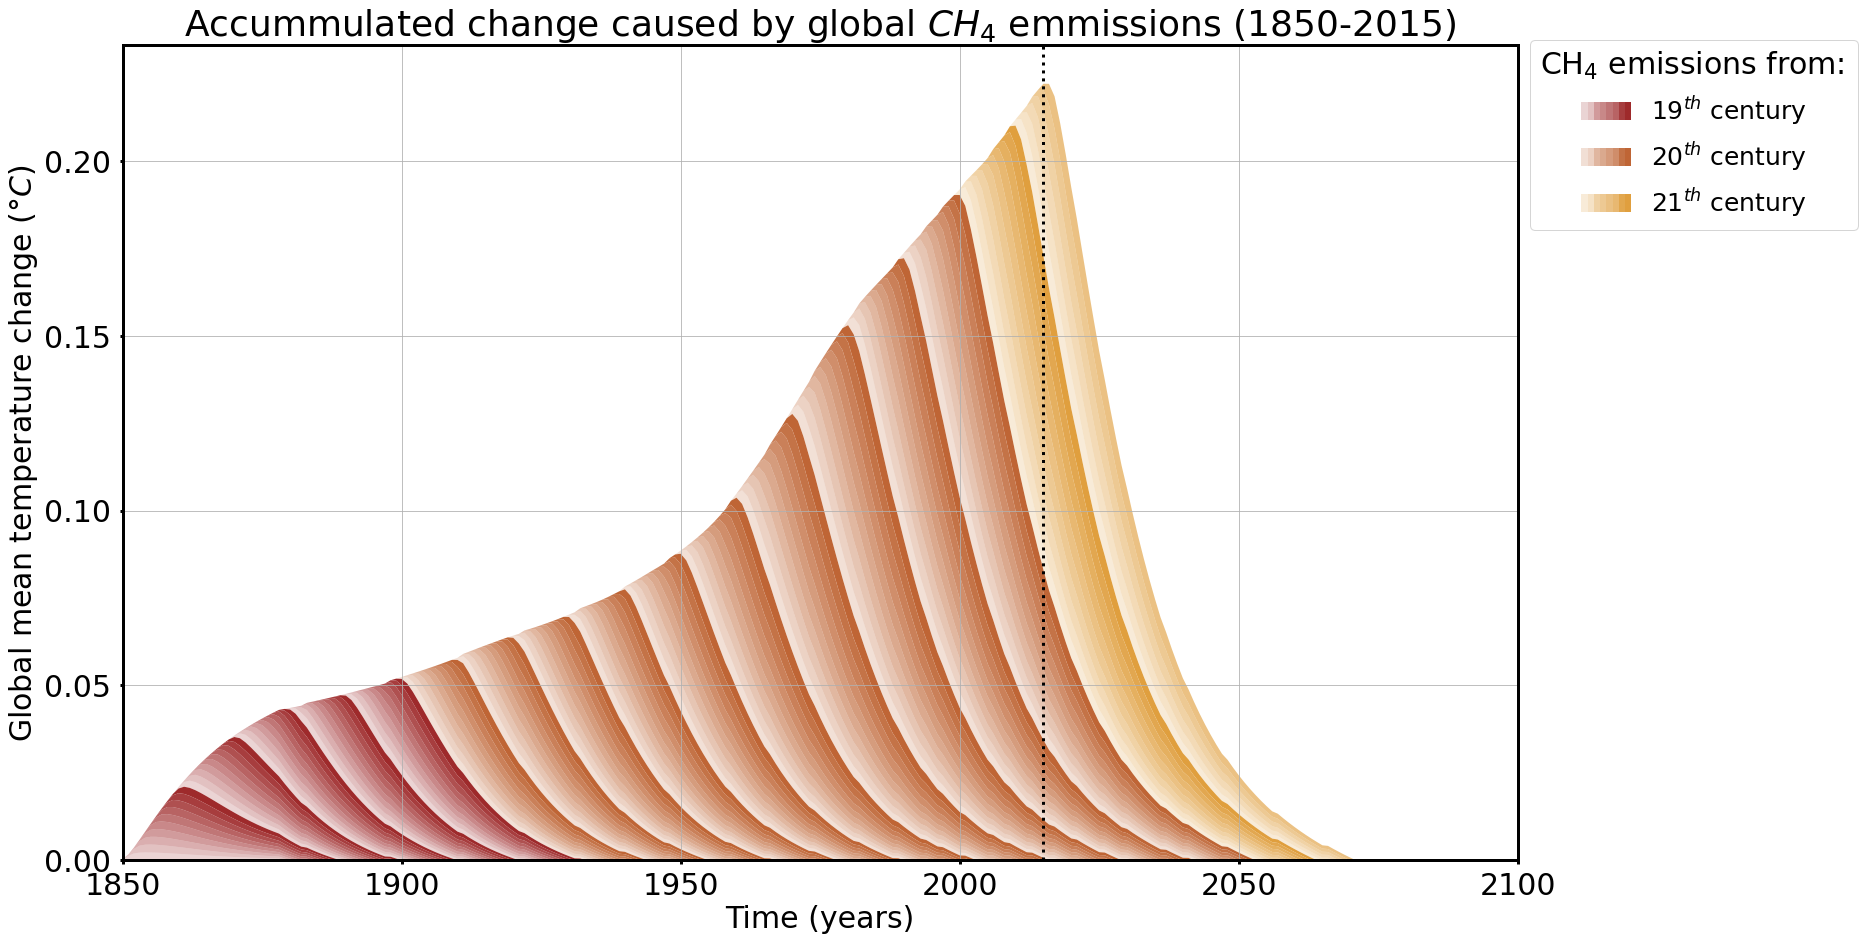

In [818]:
fig = plt.figure(figsize=(25, 15))
grid = plt.GridSpec(1, 1, hspace=0.2, wspace=0)
ax1 = plt.subplot(grid[0])

T_diff.plot.area(legend=False, linewidth=0,ax=ax1,cmap=T_cmap)

ax1.grid()
ax1.set_xlim(1850,2100)

ax1.axvline(2015,linestyle=':',c='k')

ax1.set_ylabel(r'Global mean temperature change ($\degree C$)')
ax1.set_xlabel('Time (years)', ha='center')

ax1.set_title(r'Accummulated change caused by global $CH_4$ emmissions (1850-2015)')

# legend
cmap_labels = [r'19$^{th}$ century', r'20$^{th}$ century', r'21$^{th}$ century']
cmaps=[color_to_cmap("9E2A2B"),color_to_cmap("BF6535"),color_to_cmap("E09F3E")]
# create proxy artists as handles:
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
legend1 = ax1.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,  loc='center left',bbox_to_anchor=(1, 0.89),
           fontsize=25, title= r'CH$_4$ emissions from: ')
p1 = Line2D([0], [0], color='r', lw=2)
p2 = mpatches.Patch(color='r', alpha=0.2, linewidth=0)

### Calculate per country

In [887]:
# calculate Methane percent dataset
ch4_perc=pd.DataFrame(columns=range(1850,2015))
for iso3 in ch4.index:
    ch4_perc.loc[iso3]=ch4.loc[iso3]/ch4.loc['EARTH']
ch4_perc.columns = 'yr_' + ch4_perc.columns.astype(str)

In [888]:
def dT_per_country(iso):
    return T_diff*ch4_perc.loc[iso]

def plot_dT_per_country(iso):
    df = dT_per_country(iso)
    
    fig = plt.figure(figsize=(25, 15))
    grid = plt.GridSpec(1, 1, hspace=0.2, wspace=0)
    ax1 = plt.subplot(grid[0])

    df.loc[:2100,:].plot.area(legend=False, linewidth=0,ax=ax1,cmap=T_cmap)
    ax1.axvline(2015,linestyle=':',c='k')    

    ax1.grid()

    ax1.set_xlim(1850,2100)
    
    ax1.tick_params(axis='both', which='major', pad=15)

    ax1.set_ylabel(r'Global mean temperature change ($\degree C$)')
    ax1.set_xlabel('Time (years)')

    ax1.set_title(r'Accumulated change caused by '+ coco.convert(iso,to='name_short')+', '+iso,pad=15)
    
    # legend
    cmap_labels = [r'19$^{th}$ century', r'20$^{th}$ century', r'21$^{th}$ century']
    cmaps=[color_to_cmap("9E2A2B"),color_to_cmap("BF6535"),color_to_cmap("E09F3E")]
    # create proxy artists as handles:
    cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
    handler_map = dict(zip(cmap_handles, 
                           [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
    
    plt.legend(handles=cmap_handles, 
               labels=cmap_labels, 
               handler_map=handler_map,  loc='center left',bbox_to_anchor=(1, 0.89),
               fontsize=25, title= r' CH$_4$ emissions from: ')
    


In [886]:
non_iso3=['EARTH','NONANNEXI','ANNEXI','BASIC','EU27BX','LDC','UMBRELLA','AOSIS']

In [884]:
top10 = ch4_perc.drop(non_iso3).sum(axis=1).sort_values(ascending=False).head(10).index

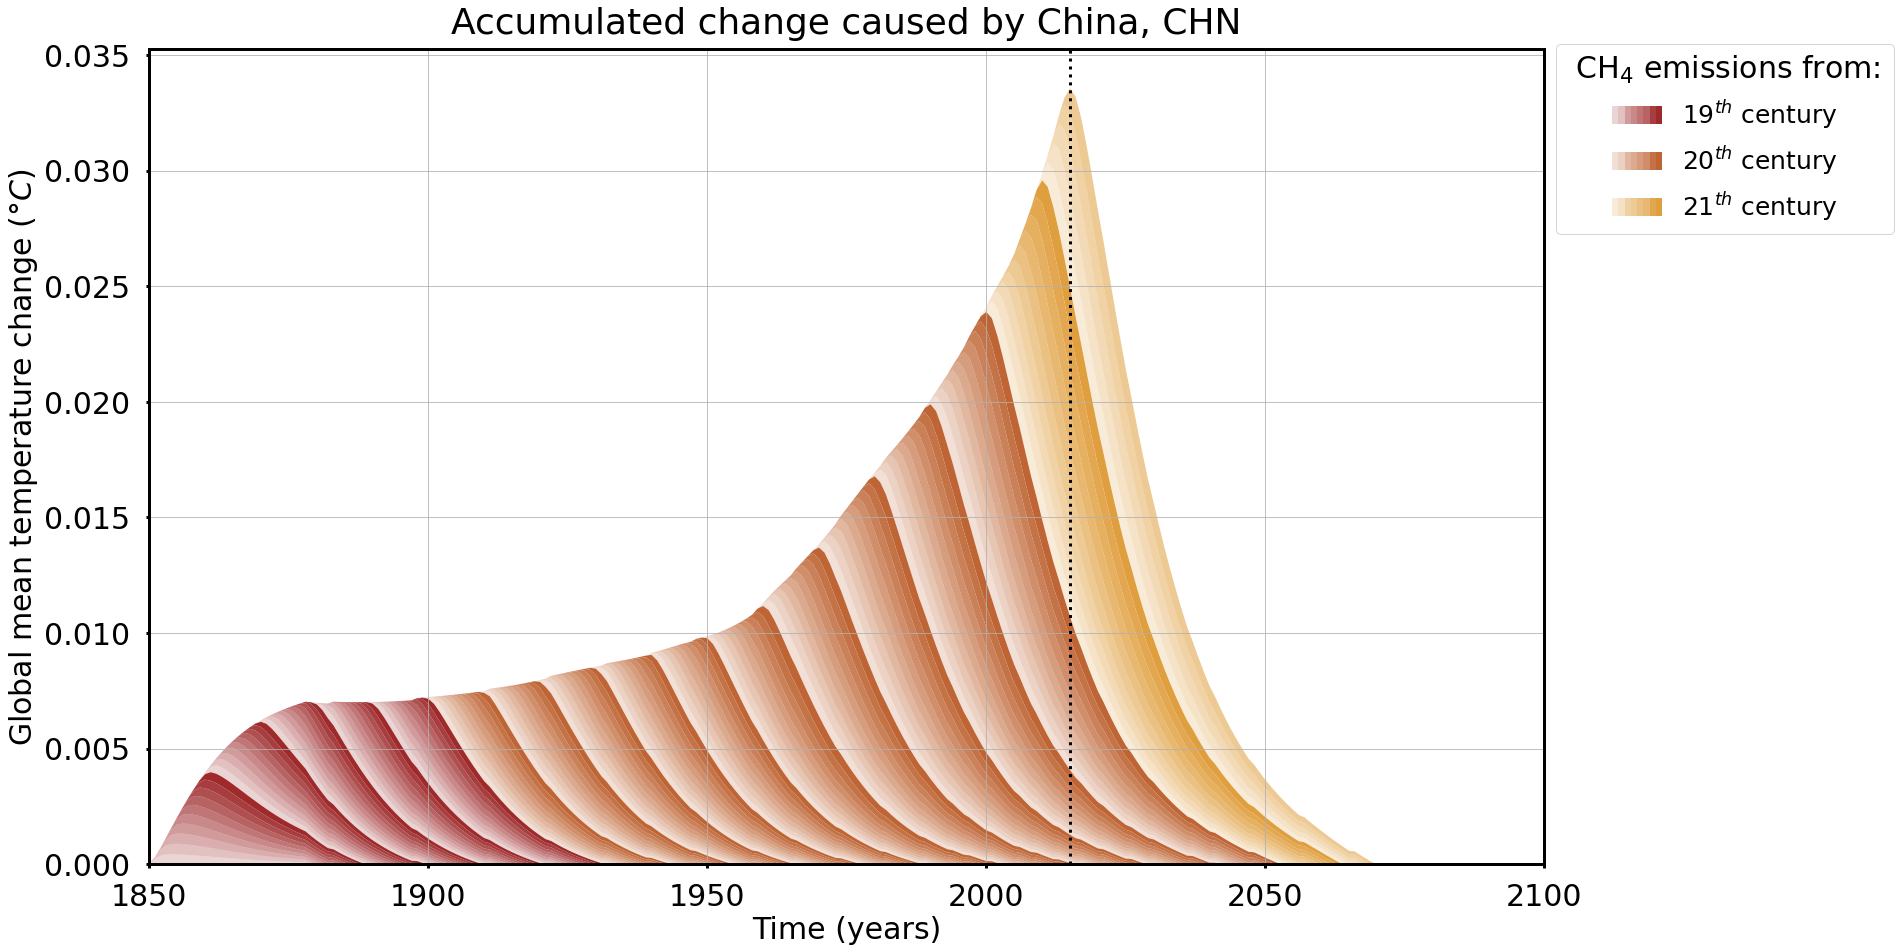

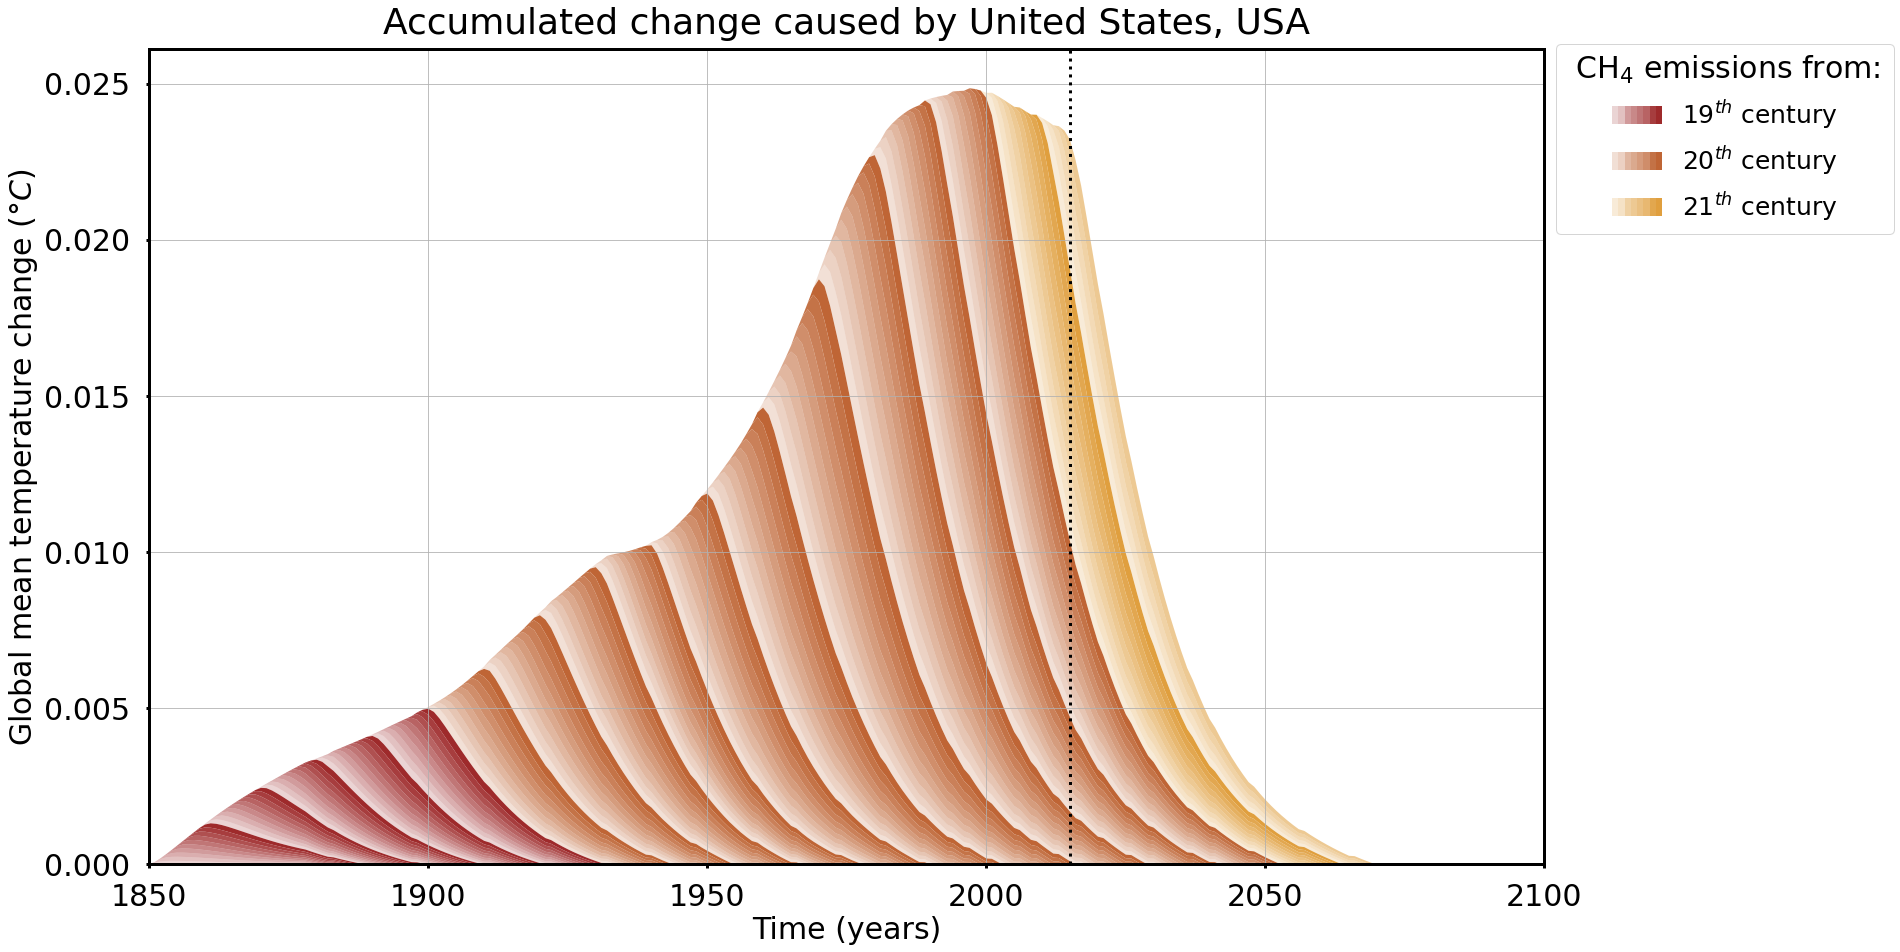

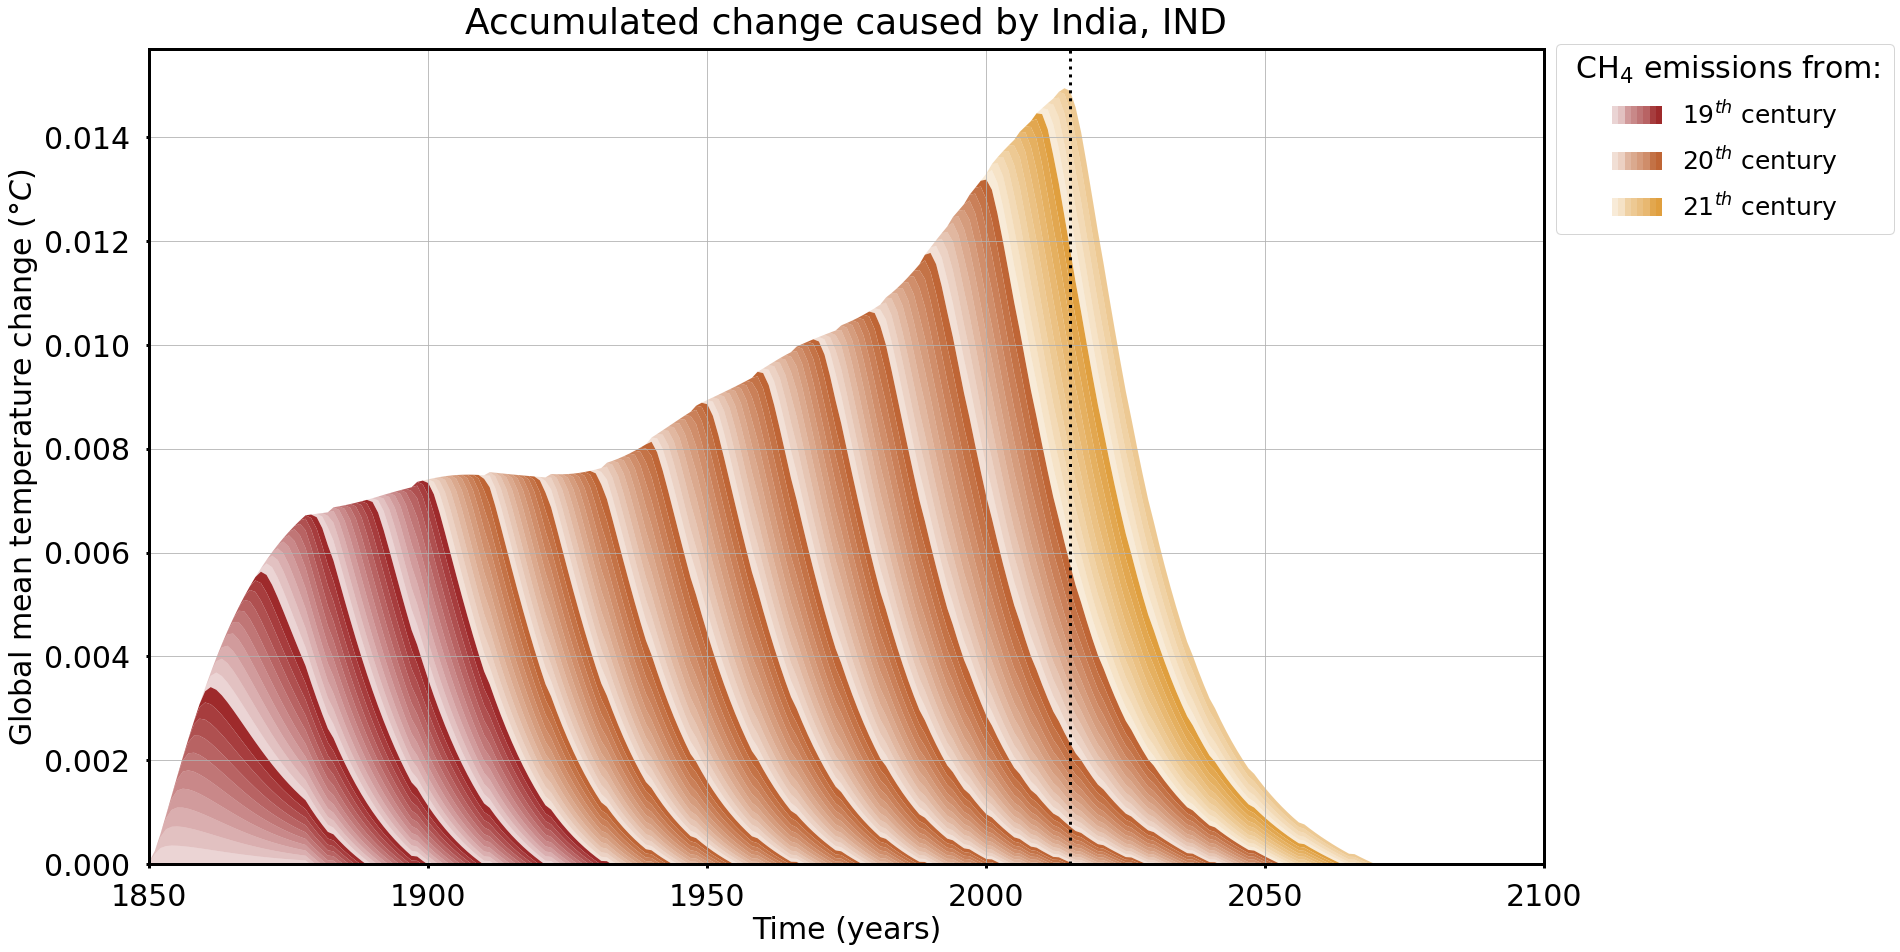

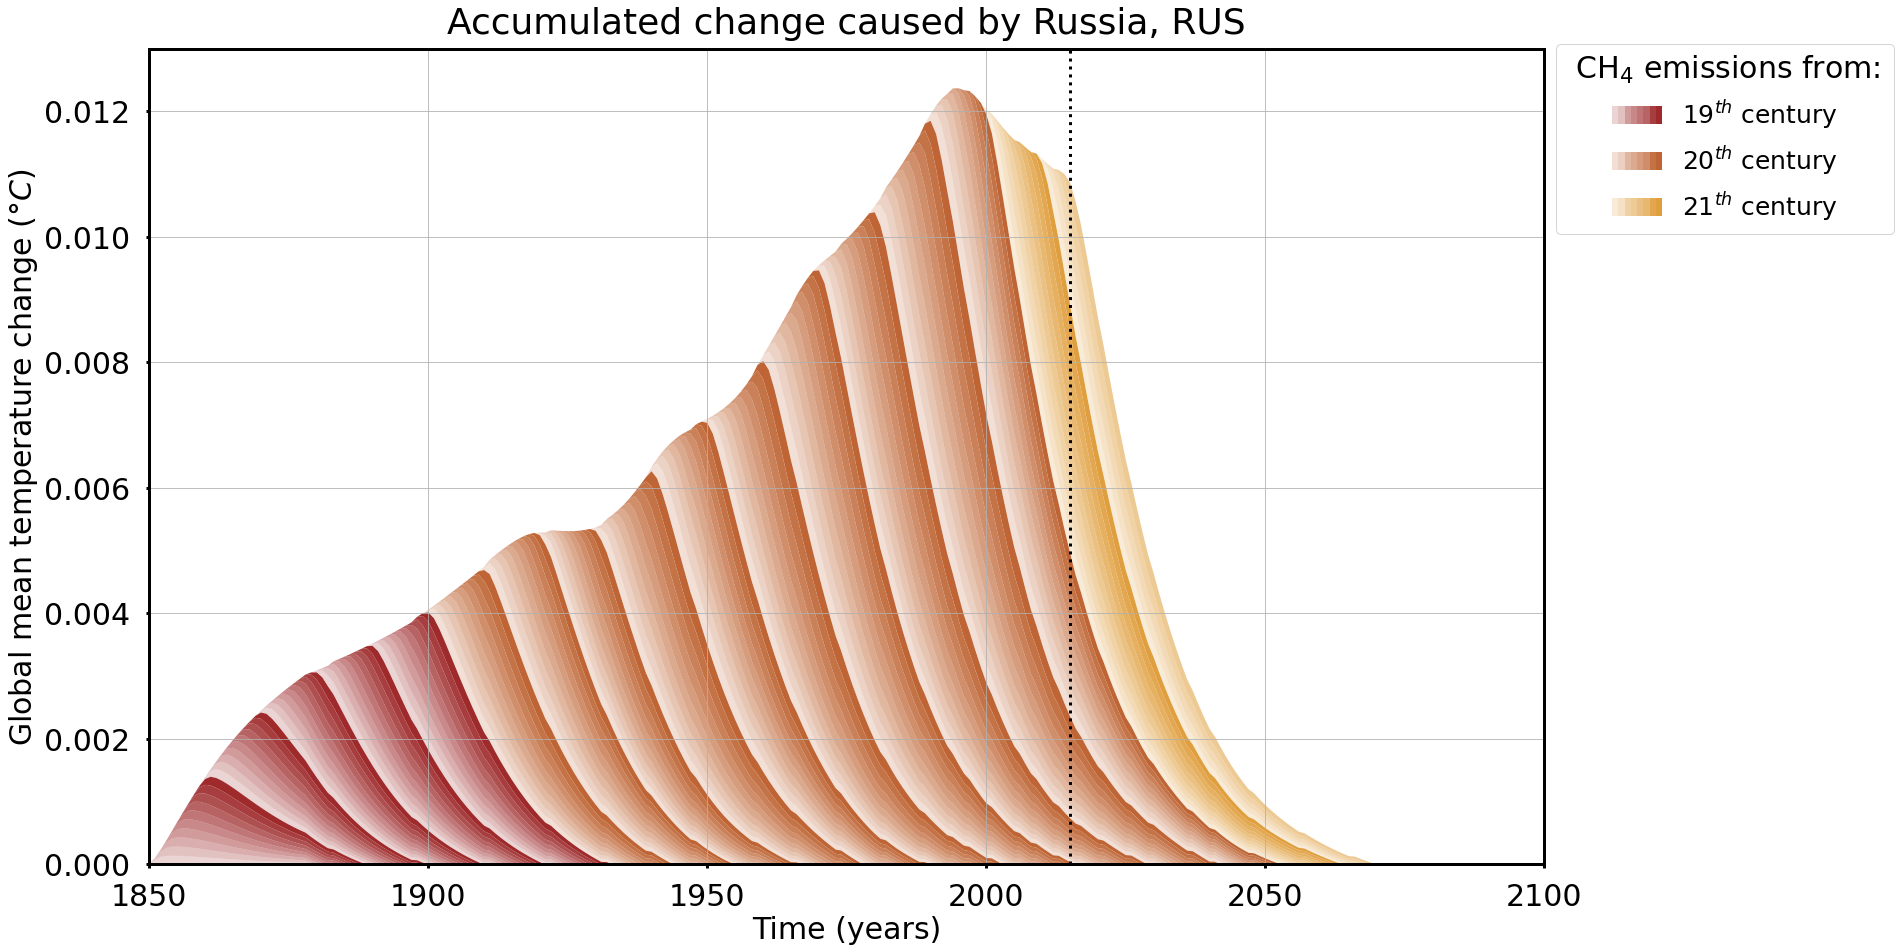

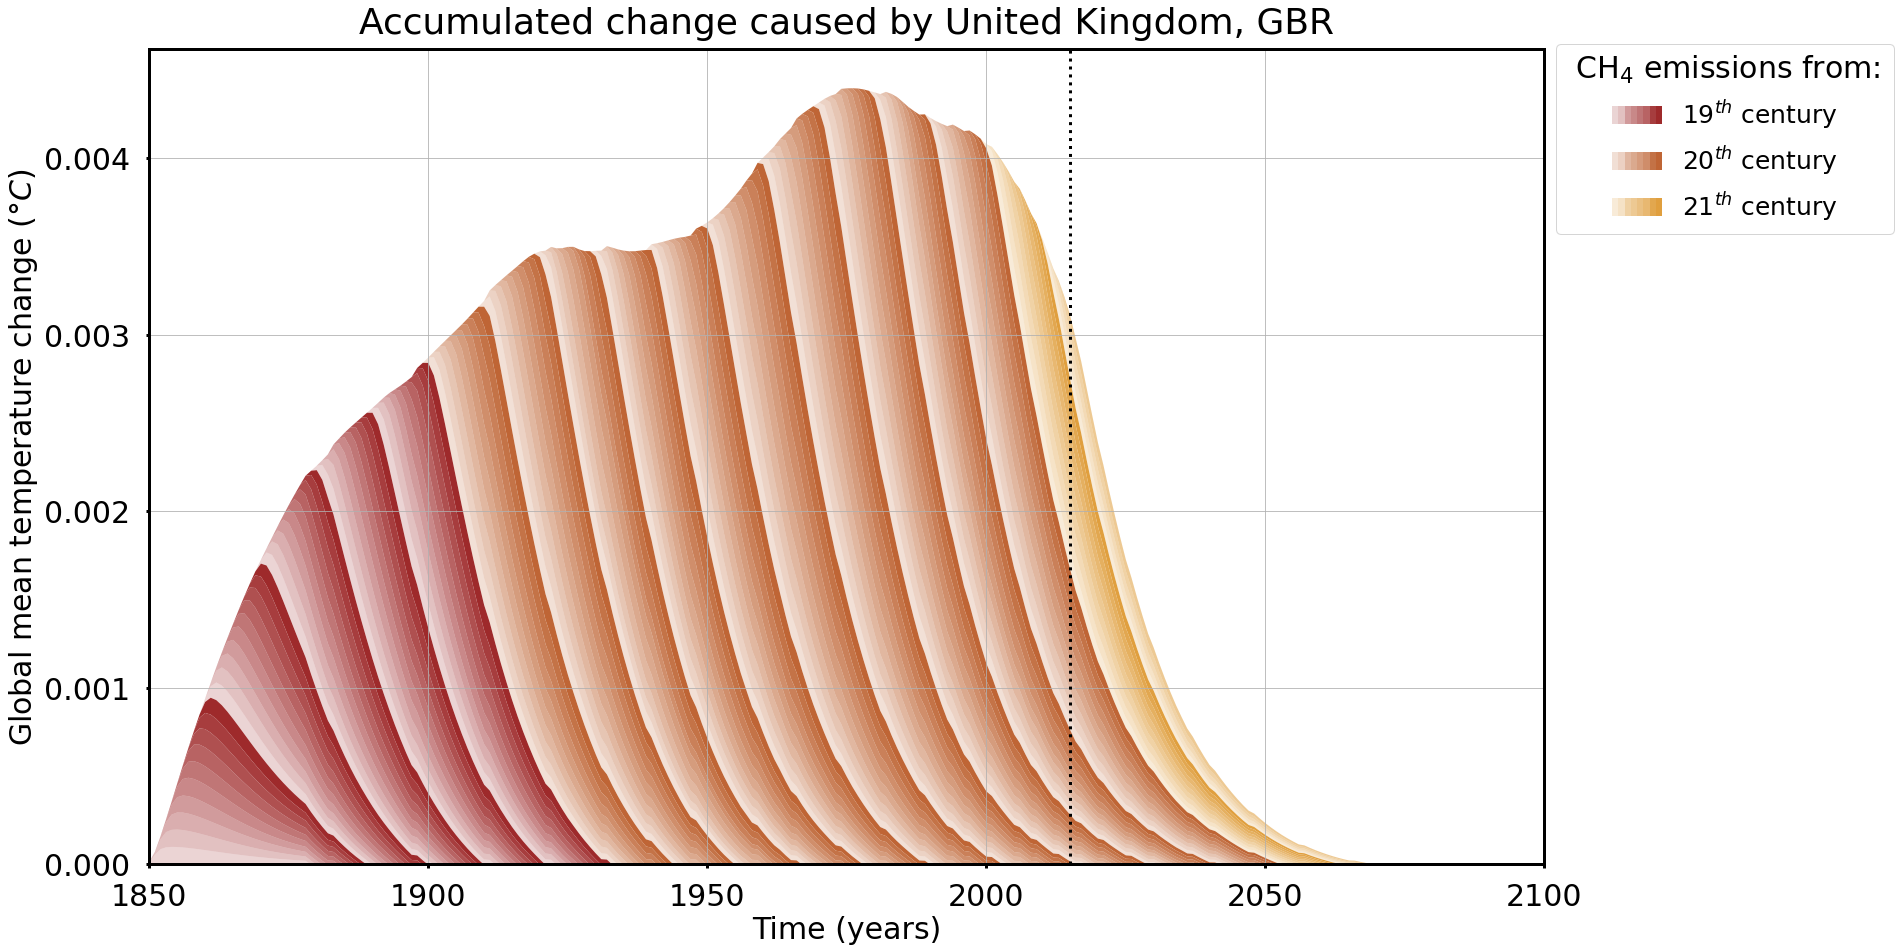

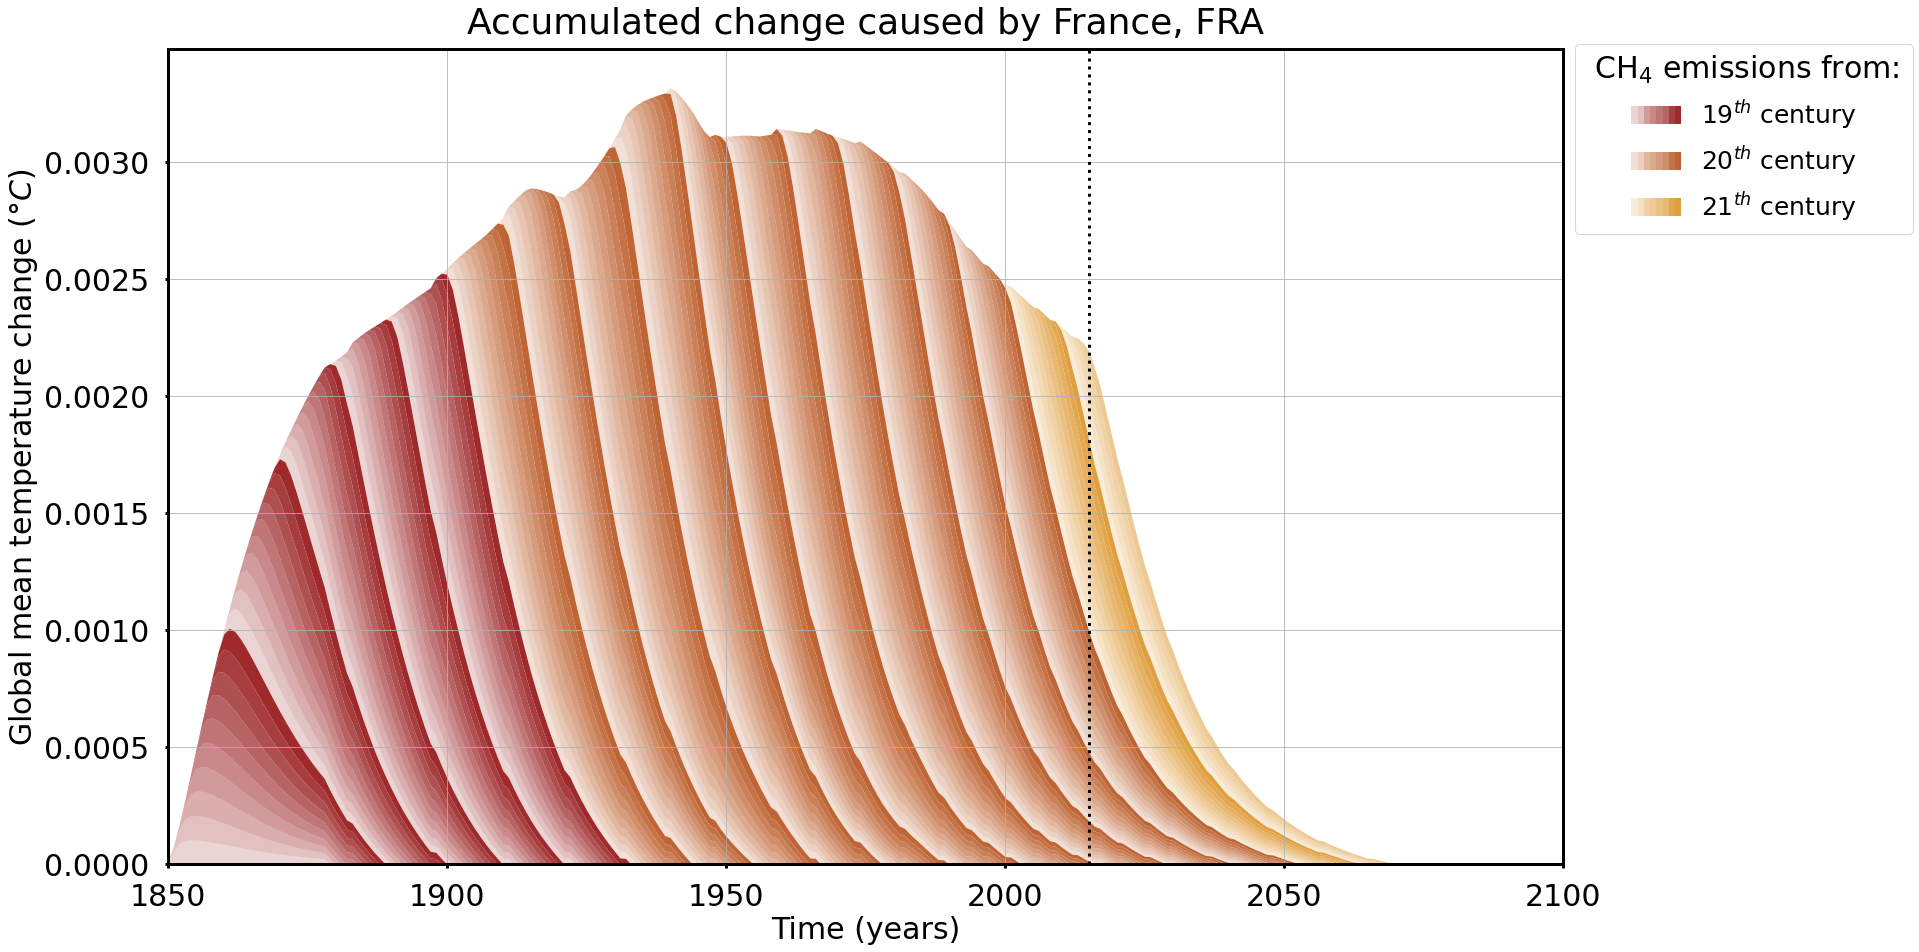

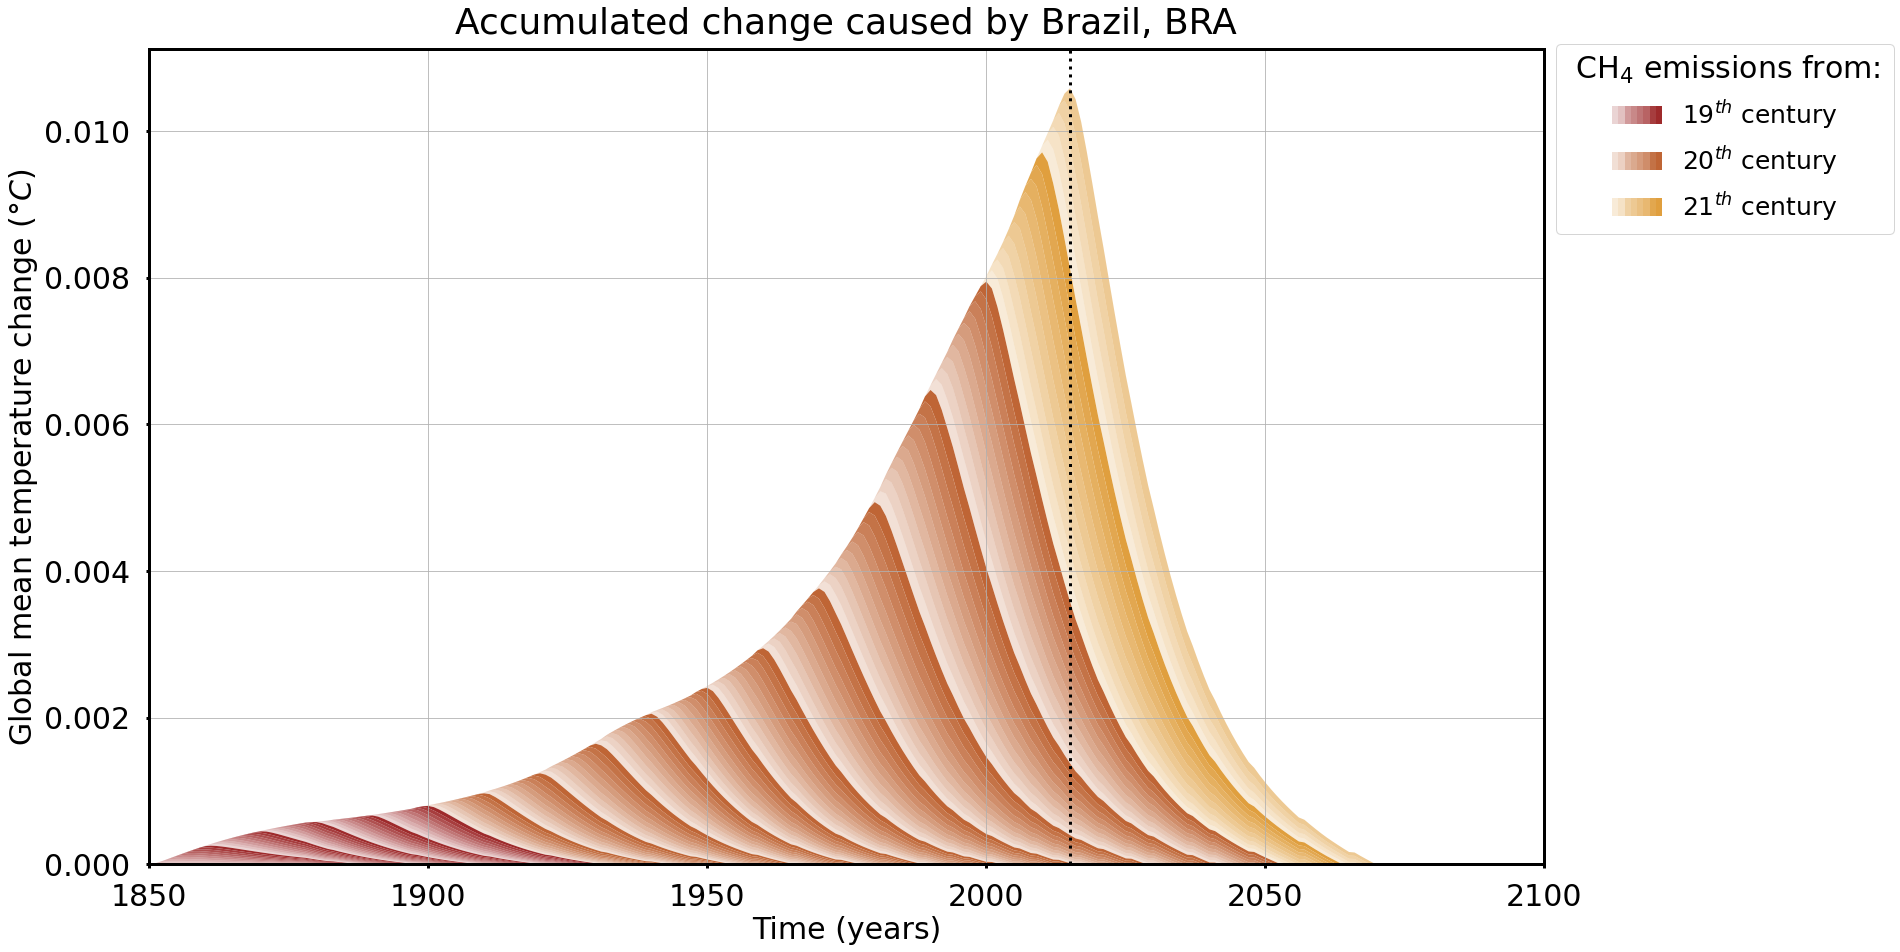

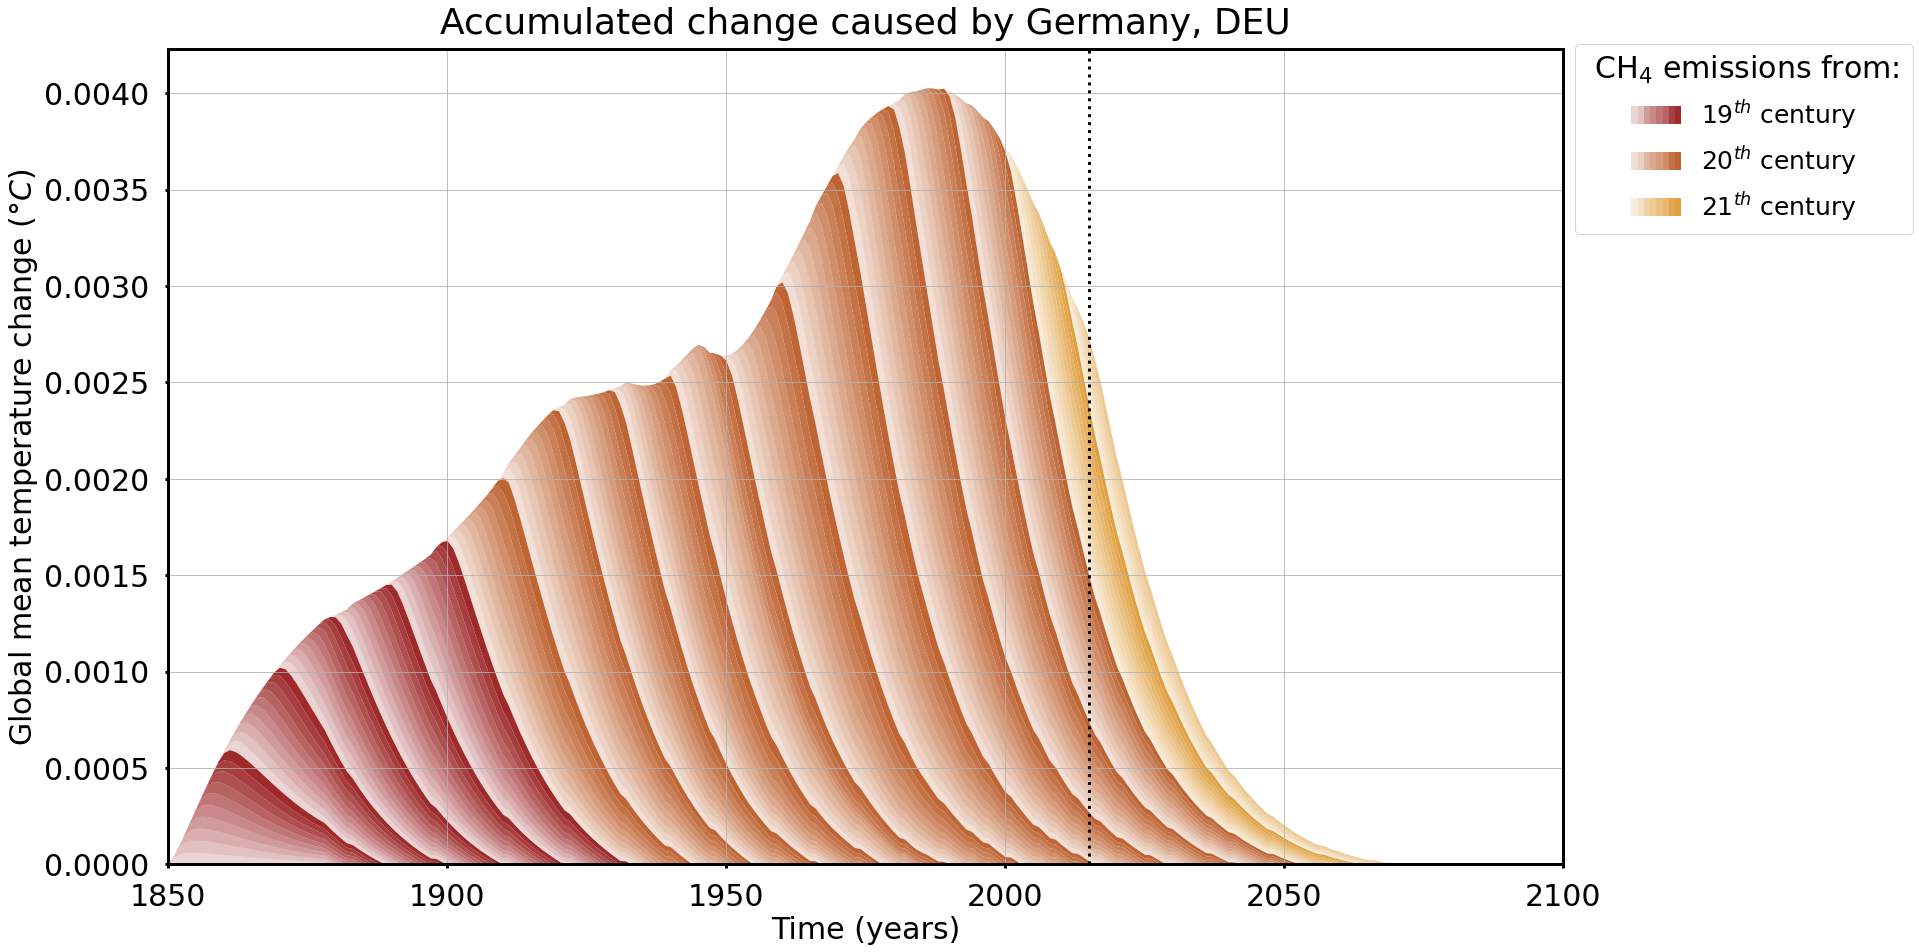

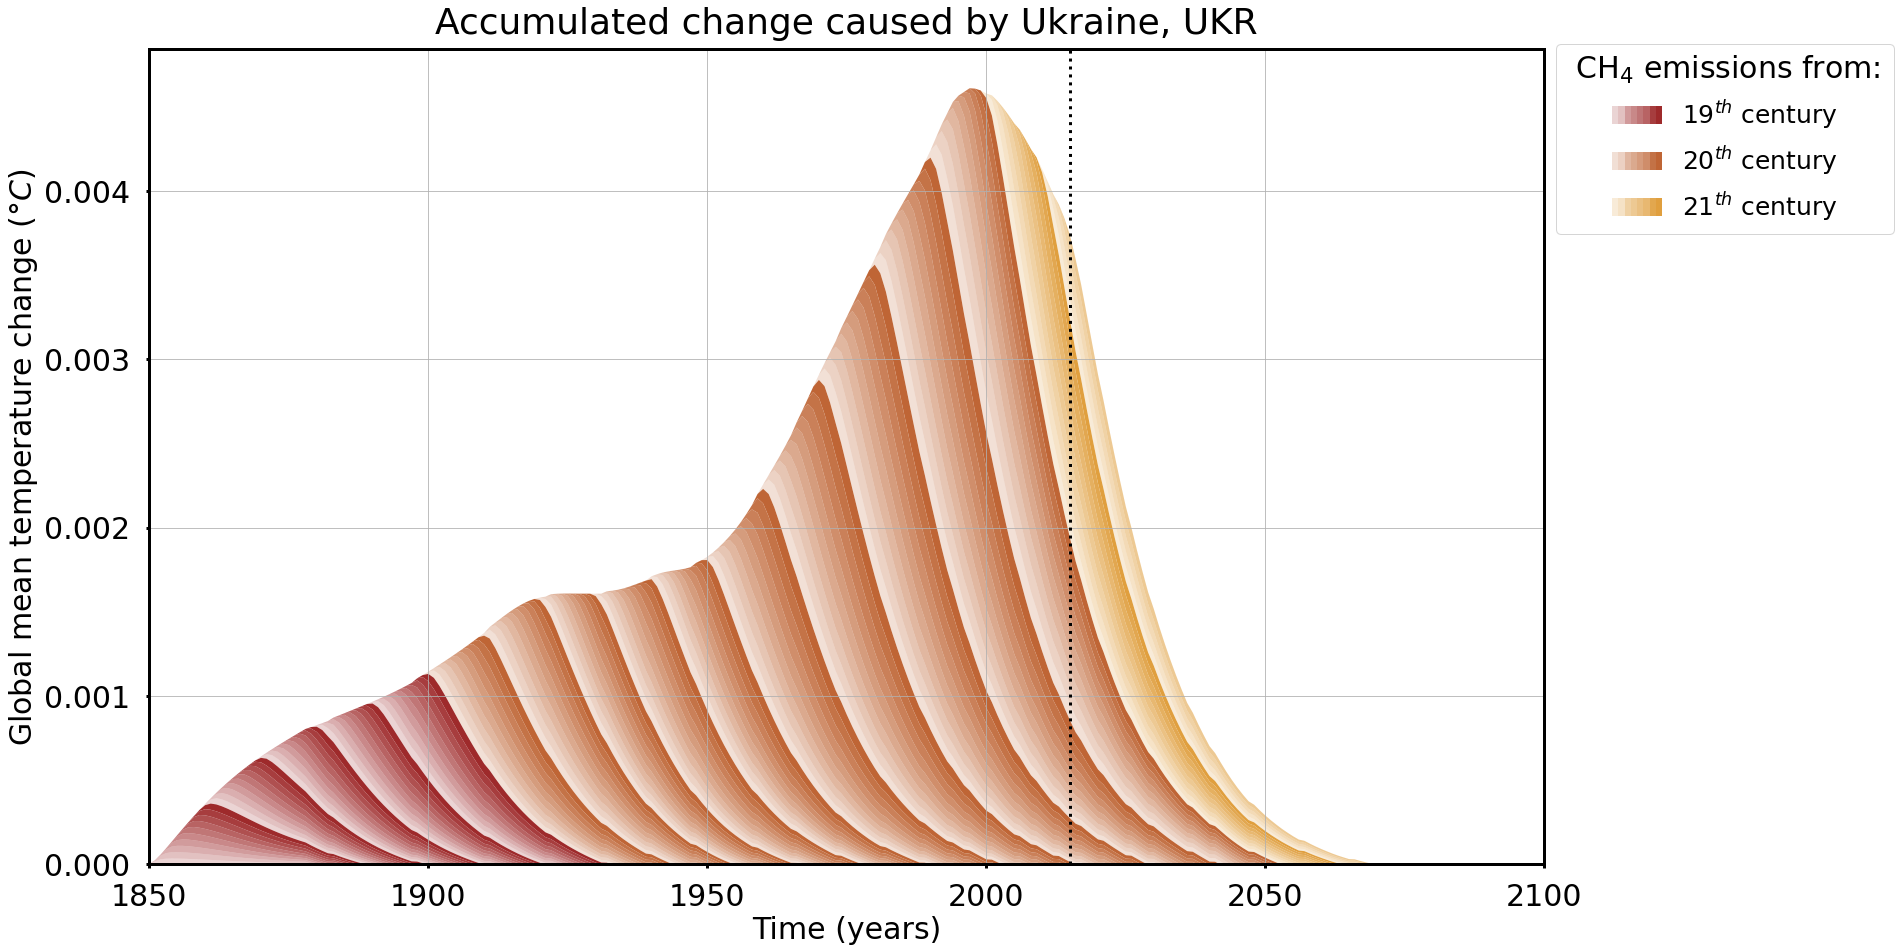

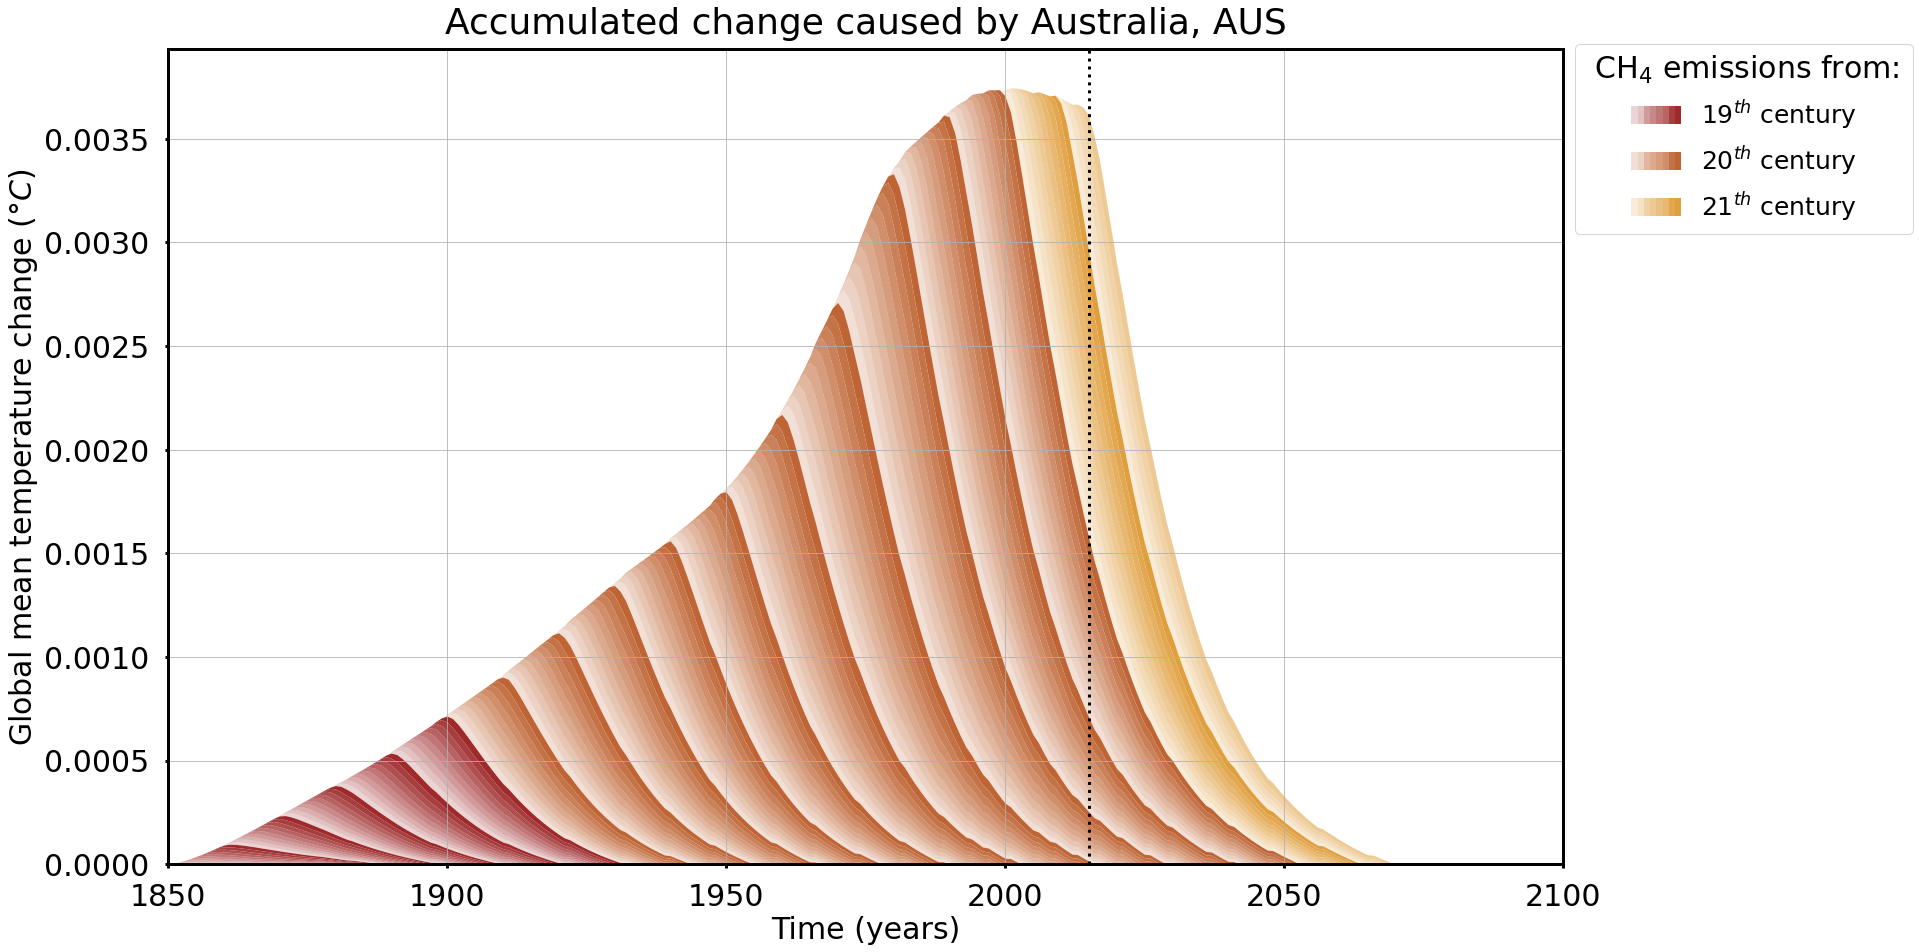

In [889]:
for iso3 in top10:
    plot_dT_per_country(iso3)

In [893]:
coco.convert(ch4_perc.drop(non_iso3).index,to='name_short')

ANT not found in ISO3


['Aruba',
 'Afghanistan',
 'Angola',
 'Anguilla',
 'Albania',
 'Andorra',
 'not found',
 'United Arab Emirates',
 'Argentina',
 'Armenia',
 'Antigua and Barbuda',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Burundi',
 'Belgium',
 'Benin',
 'Burkina Faso',
 'Bangladesh',
 'Bulgaria',
 'Bahrain',
 'Bahamas',
 'Bosnia and Herzegovina',
 'Belarus',
 'Belize',
 'Bolivia',
 'Brazil',
 'Barbados',
 'Brunei Darussalam',
 'Bhutan',
 'Botswana',
 'Central African Republic',
 'Canada',
 'Switzerland',
 'Chile',
 'China',
 "Cote d'Ivoire",
 'Cameroon',
 'DR Congo',
 'Congo Republic',
 'Cook Islands',
 'Colombia',
 'Comoros',
 'Cabo Verde',
 'Costa Rica',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Germany',
 'Djibouti',
 'Dominica',
 'Denmark',
 'Dominican Republic',
 'Algeria',
 'Ecuador',
 'Egypt',
 'Eritrea',
 'Spain',
 'Estonia',
 'Ethiopia',
 'Finland',
 'Fiji',
 'France',
 'Micronesia, Fed. Sts.',
 'Gabon',
 'United Kingdom',
 'Georgia',
 'Ghana',
 'Guinea',
 'Gambia',
 'Guinea-Bissau',
 'Equato

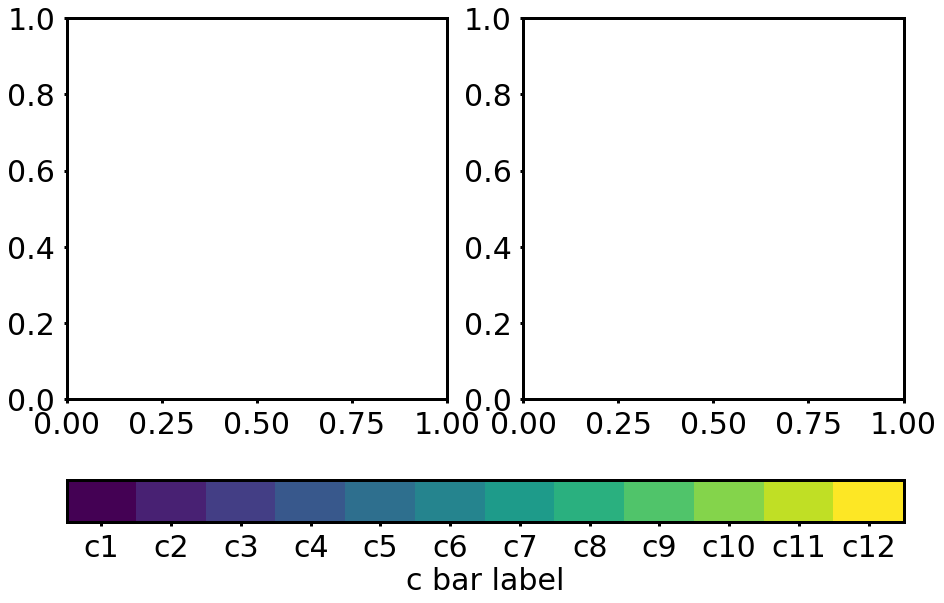

In [762]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
cmap=plt.cm.viridis
norm = mpl.colors.BoundaryNorm(np.linspace(0, 12, 13), cmap.N)
# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cax, kw = mpl.colorbar.make_axes([ax1,ax2],orientation='horizontal')
cbar = fig.colorbar(sm, cax=cax,ticks=np.linspace(0,11,12)+0.5,  **kw)
cbar.ax.set_xticklabels(['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12'])
cbar.ax.tick_params(labelsize=30)
cbar.set_label('c bar label', fontsize=30)